# Dirichlet Processes for Identifying User Groups

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import matplotlib as mpl

In [2]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
            180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ell.set_edgecolor('k')
        ax.add_artist(ell)

Draw samples.

In [3]:
# set parameters
random_state = 0
n_components = 6
n_features = 2
n_samples = 10000
scale = 1

# set component means and covariances
means = np.array([
    [2, 0],
    [4, 0],
    [1, 4],
    [5, 4],
    [2, 8],
    [4, 8]])
covars = scale * np.array([
    [[0.5, 0], [0, 1]],
    [[0.5, 0], [0, 1]],
    [[0.5, 0], [0, 2]],
    [[0.5, 0], [0, 2]],
    [[0.5, 0], [0, 1]],
    [[0.5, 0], [0, 1]]])

# set mixing probabilities
mixing_probs = np.ones((n_components)) / n_components

# get number of samples per component based on probabilities
n_samples_per_component = [int(prob * n_samples) for prob in mixing_probs]

# sample
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[i], covars[i], n_samples_per_component[i])
        for i in range(n_components)])
y = np.concatenate(
    [np.full(n_samples_per_component[i], i, dtype=int)
        for i in range(n_components)])

Cluster using finite non-Bayesian Gaussian mixture model with 10 components.

In [4]:
# cluster
gm_estimator = mixture.GaussianMixture(n_components=10, max_iter=1000)
gm_estimator.fit(X)
gm_labels = gm_estimator.predict(X)

In [5]:
np.unique(gm_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Then plot: it overfits.

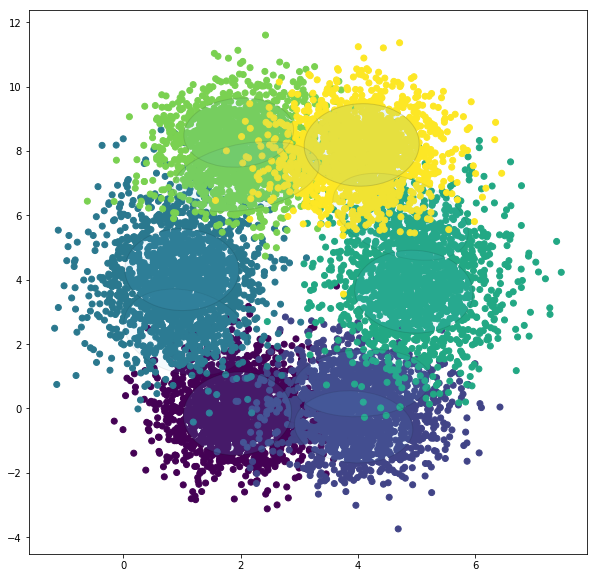

In [6]:
# plot
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_ellipses(plt.gca(), gm_estimator.weights_, gm_estimator.means_, gm_estimator.covariances_)
plt.show()

Cluster using a Bayesian approach, specifically Dirichlet process.

In [7]:
# cluster
dp_estimator = mixture.BayesianGaussianMixture(
    n_components=10, weight_concentration_prior_type='dirichlet_process', max_iter=1000)
dp_estimator.fit(X)
dp_labels = dp_estimator.predict(X)

In [8]:
np.unique(dp_labels)

array([0, 1, 2, 3, 6, 8])

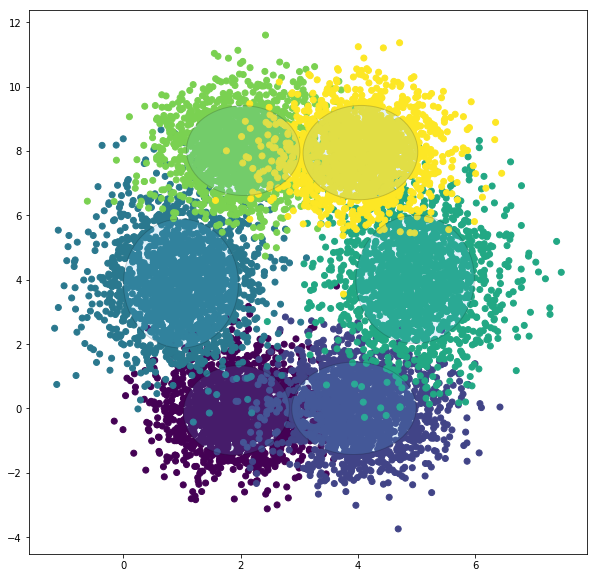

In [9]:
# plot
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_ellipses(plt.gca(), dp_estimator.weights_, dp_estimator.means_, dp_estimator.covariances_)
plt.show()

What kinds of problems can be tackled using an unsupervised approach?

## User Type Identification for Analyzing Artist Engagement

### Problem

It can be used to model an artist's listeners. Listeners can be divided into categories using several criteria, including listening behavior and demographics. If we just look at listening behavior, listeners are naturally divided into categories based on how frequently they listen to an artist. A user can be someone who listens regularly ("a diehard fan"), who listens from time to time (perhaps stemming from a general interest in the genre), or who listens once or twice (e.g., if they're discovering). In this model, a listener can be a diehard fan of certain artists while a casual fan of others. How many categories are there? With a large and complex dataset, it's unclear how many there are apriori.

### Models

Parametric clustering methods can be used to cluster the data, but they assume the number of clusters is known beforehand. Manually iterating on that parameter to improve performance may be costly and could lead to overfitting. A nonparametric approach, which lets the number of clusters grow with the data, might work better. Two approaches could be used.

#### Dirichlet process Gaussian mixture model

A Dirichlet process is used to model a variable number of listener groups. Sampling the Dirichlet process results in a distribution over cluster parameters for different listener groups. A sample from that distribution leads to a parameter which defines a Gaussian distribution over the observation, which is some measure of streams on the user level. Several options for modeling the observation are possible.

The observations can be a vector of streams for different artists. Each observation could correspond to a different day or averaged over days. Because there are a lot of artists, dimensionality reduction would need to be used to reduce the artist set to a manageable size. But in this model, each cluster would correspond to users who listen to similar artists to similar degrees (i.e., not just to diehard fans versus casual listeners). These could be used to determine other artists that listeners of a given artist also listen to, but it's unclear what the value of this would be.

The observations can be simply streams for a given artist (at a given timescale). Then each cluster would correspond to the categories sketched above. For example, a user who listens a lot to AWOLNATION would be grouped with another who listens a lot to G Herbo. Both users likely appear in other groups depending on how frequently they listen to other artists.

Other observations can also be included to capture additional information. For example, if one is interested in distinguishing users based not only on how often they listen, but also when they listen, the observation can be extended to encode streams at different times (e.g., day versus night, weekday versus weekend, summer versus winter). Also, streams could be broken down into streams from different sources (e.g., collection versus playlist). This added breakdown would probably help distinguish between listeners of different interest levels.

A weakness with the DP-GMM approach is that it doesn't explicitly model users' listening behavior on an artist level. To see how users for a given artist break down into each category of user, those users must be rerun through the final model to determine their cluster assignments. But this fails to capture explicitly how artists have different distributions over fans, who nonetheless exhibit the same kinds of qualities (e.g., diehard versus casual). This issue is addressed with the next approach.

#### Hierarchical Dirichlet process

A HDP is simply a DP with an additional layer: the base measure of the DP is a draw from another DP. In our case, the idea is that there's a common set of user types across the entire catalog, but each individual artist would have a different distribution over these user types. For example, a popular, established artist might have more diehard fans and fewer one-time listeners, while the opposite might be true for a lesser known artist. These different distributions would lead to the different stream levels artists observe. Alternatively viewed as a generalization of Latent Dirichlet Allocation (LDA), this approach has traditionally been used in topic modeling for text documents. The analogy for the current problem is that topics correspond to users, documents to artists, and words to streams. As a document can discuss several topics, and topics determine words, so too an artist has users, and users determine streams. The assumption is that each word (streams) in a document (for an artist) is independent given the topic (user).

### Applications

This kind of modeling has several applications. For one, a breakdown of an artist's fanbase into users of different interest and commitment levels, together with expected streams for each of these user types, would probably be informative in its own right. Additionally, listener metadata like demographics can be used to estimate distributions over that metadata for each cluster, for a given artist. That could tell you, for example, that X% of users who are on the brink of being diehard fans are from this region, or from this age-gender cross-section.

Another application would be artist indexing based on listener engagement. An artist can be manually compared to other artists who are further along in their careers to see how their listener distributions compare. This might be able to drive strategic decisionmaking. Also, artists can be clustered with each other based on their listener distributions. Then any given artist in a group can be compared to group statistics excluding the artist, benchmarking against artists with similar engagement levels.

Another, more remote application would be for artist streams forecasting for new releases. It's hard to predict streams for an artist's new release because there are no historical streams for the release. It's possible to average streams for past releases or for similar artists, but this ad hoc approach fails to capture the underlying process that leads to streams. But if we have a sense of an artist's fanbase at the time of release, that can be used to determine how many streams the release will get. Diehard fans will probably listen, while casual listeners might not. Additional modeling may be necessary, and it might be beneficial to model time evolution using an HDP variant of an HMM (HPD-HMM), but this might be a fruitful line of work.

### Alternatives

The prior approach described how to segment users based on artist streams in order to better understand artists' fanbases. But it's possible to break down users in other ways, without reference to how they listen to different artists. There are several ways to do this. For example, listeners can be clustered based on how frequently they listen to different genres. The observations would be some measure of how frequently a user streams songs from different genres, at a certain timescale (e.g., daily or yearly). Inferred groups would correspond to things like users who listen heavily to rap, but sometimes to rock or jazz. But what analyses could these groups support? It's unclear. Insights are usually desired on the artist or release level. Distributions of user tastes can be inferred for an artist or release, but it's unclear what value that information would have.

Of course, clusters could be identified based on demographics, but clustering in this way doesn't give you a sense of how influential those groups are in impacting streams. Clustering based on streams, then estimating demographics distributions for each cluster seems more sensible.

### Data

As a first cut, the training set can consist of user data from a sampling of artists. First, sample a set of artists. They can be sampled from the total set of artists, or hierarchically from sets of artists of different popularity levels. For each artist, sample a set of users who listened to that artist in a given period (e.g., the last year). This can also be done directly or hierarchically. The observations can be modeled in several different ways, as outlined above. For simplicity, each observation can consist of the average daily times the user has listened to the artist from collection, active discovery, and passive discovery over the time period. This can be computed by summing the summing streams and dividing by 365. These observations would need to be scaled or normalized to put them on a similar scale to permit clustering.

### Software

There are several options.

1. Gensim. This is an open-source Python library for topic modelling, document indexing, and similarity retrieval with large corpora. Based on the activity on GitHub, this seems like a pretty popular option. It supports LDA and HDP. It also conveniently has an sklearn-like API. One limitation is that, being tailored to topic modeling, the observations are assumed to be mulinomial (e.g., number of times words appear). Discretization would be needed in this case. Code at https://github.com/RaRe-Technologies/gensim.
2. bnpy. An open-source Python library for Bayesian nonparametric modeling. It supports DP mixtures, HDPs, and HDP-HMMs, but there's not a good history on GitHub. Code at https://github.com/bnpy/bnpy.
3. datamicroscopes. Their LDA repository supports HDPs. Code at https://github.com/datamicroscopes/lda.

In [489]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.sklearn_api import HdpTransformer

In [494]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [492]:
print(common_dictionary.token2id)

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


In [498]:
print(common_dictionary.doc2bow(['minors', 'computer', 'a', 'minors']))

[(0, 1), (11, 2)]


In [508]:
import gensim
numpy_matrix = np.random.randint(10, size=[5, 2])  # dims are [num_words, num_documents]
corpus = gensim.matutils.Dense2Corpus(numpy_matrix)

In [509]:
for c in corpus:
    print(c)

[(0, 7.0), (1, 2.0), (2, 7.0), (4, 6.0)]
[(0, 8.0), (1, 1.0), (2, 6.0), (4, 5.0)]


In [511]:
print(numpy_matrix)

[[7 8]
 [2 1]
 [7 6]
 [0 0]
 [6 5]]


In [519]:
numpy_matrix_recon = gensim.matutils.corpus2dense(corpus, num_terms=5)
print(numpy_matrix_recon)

[[7. 8.]
 [2. 1.]
 [7. 6.]
 [0. 0.]
 [6. 5.]]


In [530]:
model = HdpTransformer(id2word=common_dictionary)
distr = model.fit_transform(common_corpus)

In [539]:
distr

array([[0.0674817 , 0.79209524, 0.03573838, 0.02660223, 0.01991623,
        0.01487617, 0.01116349, 0.        , 0.        ],
       [0.03821892, 0.02731436, 0.87466115, 0.01518765, 0.01138007,
        0.        , 0.        , 0.        , 0.        ],
       [0.05462153, 0.8330645 , 0.02858502, 0.02126402, 0.01593195,
        0.01190093, 0.        , 0.        , 0.        ],
       [0.5497595 , 0.33794796, 0.02855861, 0.02126882, 0.01593212,
        0.01190093, 0.        , 0.        , 0.        ],
       [0.06511916, 0.04799717, 0.7822285 , 0.02657427, 0.01991466,
        0.01487617, 0.01116349, 0.        , 0.        ],
       [0.12562628, 0.09433752, 0.5706714 , 0.05319931, 0.03983301,
        0.02975237, 0.02232698, 0.01665916, 0.01236136],
       [0.3637885 , 0.06376983, 0.43286598, 0.03546564, 0.02655506,
        0.01983491, 0.01488465, 0.01110611, 0.        ],
       [0.25968426, 0.04835501, 0.58729327, 0.0265857 , 0.01991554,
        0.01487618, 0.01116349, 0.        , 0.        ],


In [541]:
print(model.transform([(0, 1), (1, 1), (2, 1)]))

[[0.0674817  0.79209524 0.03573838 0.02660223 0.01991623 0.01487617
  0.01116349]]


In [3]:
# use sklearn to preprocess the input (i.e., discretize)
from sklearn.preprocessing import KBinsDiscretizer

rnd = np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)
y = np.sin(X) + rnd.normal(size=len(X)) / 3
X = X.reshape(-1, 1)

# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='ordinal')
X_binned = enc.fit_transform(X)

## Data

In [2]:
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.sql import select
import pandas as pd

In [3]:
# establish Snowflake connection
user = ''
password = ''
schema = ''

engine = create_engine(URL(
    user=user,
    password=password,
    account='orchard',
    database='dev_engineering',
    schema=schema,
    role='dev_engineering',
    warehouse='dev_performance_warehouse'))

In [4]:
table_name = 'user_artist_streams_unique_artist_sample'
table = Table(table_name, MetaData(), autoload=True, autoload_with=engine)
df = pd.read_sql(select([table]), engine)

In [5]:
df.head()

,artistname,canonical_artistid,userid,total_streams
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318


In [6]:
print('Number of artist-user pairs is', len(df))

Number of artist-user pairs is 38776575


Save artist-listener-streams tuples to CSV.

In [ ]:
df.to_csv(
    'artist_listener_tuples.csv', header=False, index=False,
    columns=['canonical_artistid', 'userid', 'total_streams'])

## Preprocessing

The following describes preprocessing that needs to be done to bin streams for use in a hierarchical Dirichlet process approach, which assumes the observation is discrete.

### Log Streams

First calculate log streams. The idea is that the log will squeeze together values that are far apart to help with binning. For example, if a user listened 1000 times and another 2000 times, with standard binning they're likely to be in different bins. However, in log space, those values are 6.9 and 7.6, respectively, so they might get assigned to the same bin, which is good if both users qualitatively represent high streaming numbers. Of course, a quantile-based binning strategy might help alleviate this problem, but computing the log is one alternative.

In [7]:
df['log_total_streams'] = np.log(df['total_streams'])

In [8]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051


In [9]:
df.describe()

,canonical_artistid,total_streams,log_total_streams
count,3.877658e+07,3.877658e+07,3.877658e+07
mean,6.871134e+05,2.428444e+02,5.253981e+00
std,2.540722e+05,5.055677e+02,5.755562e-01
min,2.935200e+04,1.010000e+02,4.615121e+00
25%,5.178840e+05,1.230000e+02,4.812184e+00
50%,7.518630e+05,1.630000e+02,5.093750e+00
75%,9.152320e+05,2.530000e+02,5.533389e+00
max,1.349592e+06,2.956820e+05,1.259704e+01


Now look at a histogram of streams and log streams. As expected, log streams are more evenly distributed.

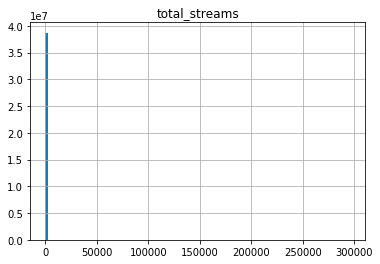

In [11]:
df.hist(column='total_streams', bins=100);

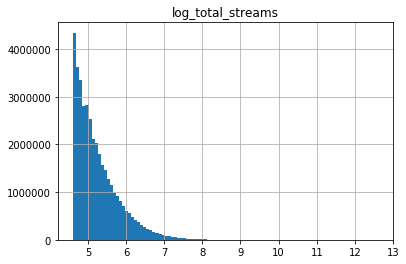

In [12]:
df.hist(column='log_total_streams', bins=100);

### Scaling

Another way of getting the streams on a similar scale is simply to the scale the data. This can be done several ways. Here we explore three different methods.

#### Average Daily Streams

In this first approach, we simply scale by 1/365 to get average daily streams.

In [10]:
df['avg_daily_streams'] = df['total_streams'] / 365

In [14]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233


#### Min/Max Scaling

In the second approach, we scale the streams to the range 0 (global minimum streams) to 1 (maximum streams).

In [11]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df['total_streams_min_max_scaled'] = min_max_scaler.fit_transform(
    df['total_streams'].values.reshape(-1, 1).astype(float))

In [16]:
print(df['total_streams_min_max_scaled'].min(), df['total_streams_min_max_scaled'].max())

0.0 0.9999999999999999


In [17]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068,0.000047
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849,0.000037
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205,0.000085
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110,0.000034
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233,0.000734


#### Max/Abs Scaling

In the third approach, we scale by the maximum value.

In [12]:
from sklearn.preprocessing import MaxAbsScaler

max_abs_scaler = MaxAbsScaler()
df['total_streams_max_abs_scaled'] = max_abs_scaler.fit_transform(
    df['total_streams'].values.reshape(-1, 1).astype(float))

In [19]:
print(df['total_streams_max_abs_scaled'].min(), df['total_streams_max_abs_scaled'].max())

0.00034158318734315923 1.0


In [20]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled,total_streams_max_abs_scaled
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068,0.000047,0.000389
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849,0.000037,0.000379
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205,0.000085,0.000426
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110,0.000034,0.000375
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233,0.000734,0.001075


### Discretization

Next we need to discretize streams. This can be done using a quantile or uniform strategy.

#### Quantile Binning

With quantile discretization, the bin edges are computed so that each bin has a similar number of points. Because there are many fewer users with high levels of streams, the last bins will be really wide so that more users can be placed in them.

First we discretize total streams using 150 bins.

In [13]:
# discretize
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 150

enc_quantile_150 = KBinsDiscretizer(n_bins=n_bins, strategy='quantile', encode='ordinal')
total_streams_quantile_binned = enc_quantile_150.fit_transform(
    df['total_streams'].values.reshape(-1, 1))

The bin assignments look like this.

In [22]:
print(total_streams_quantile_binned)

[[ 26.]
 [ 21.]
 [ 41.]
 ...
 [ 86.]
 [100.]
 [ 24.]]


The number of unique bin assignments looks like this.

In [14]:
unique_bin_labels = np.unique(total_streams_quantile_binned).astype(int)
print(unique_bin_labels)

[  2   4   5   7   9  11  13  15  16  18  20  21  23  24  26  27  29  30
  32  33  34  36  37  38  40  41  42  43  44  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149]


In [15]:
print('Number of bin assignments is', len(unique_bin_labels))

Number of bin assignments is 133


The bin edges for those bins look like this. The first bin (id = 2 above) corresponds to streams greater than or equal to 101 but less than 102 (i.e., equal to 101), the second bin to 102, and so on. The last bin corresponds to 1475 streams or more. The problem with this binning of course is that many of the first bins have widths of one, making it hard to distinguish between them, while the last bins are very wide.

In [25]:
bin_edges = enc_quantile_150.bin_edges_[0][unique_bin_labels]
print(bin_edges)

[ 101.  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.  112.
  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.  124.
  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.  135.  136.
  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.  147.  149.
  150.  151.  152.  153.  155.  156.  157.  159.  160.  162.  163.  164.
  166.  167.  169.  171.  172.  174.  176.  177.  179.  181.  183.  185.
  187.  189.  191.  193.  195.  197.  200.  202.  204.  207.  209.  212.
  215.  217.  220.  223.  226.  230.  233.  236.  240.  243.  247.  251.
  255.  259.  264.  269.  273.  278.  284.  289.  295.  301.  307.  314.
  321.  329.  337.  345.  354.  364.  374.  385.  397.  410.  425.  440.
  458.  477.  499.  523.  551.  584.  623.  670.  729.  807.  918. 1095.
 1475.]


Below are the bin widths. Notice how they jump up exponetially.

In [26]:
bin_widths = np.diff(bin_edges)

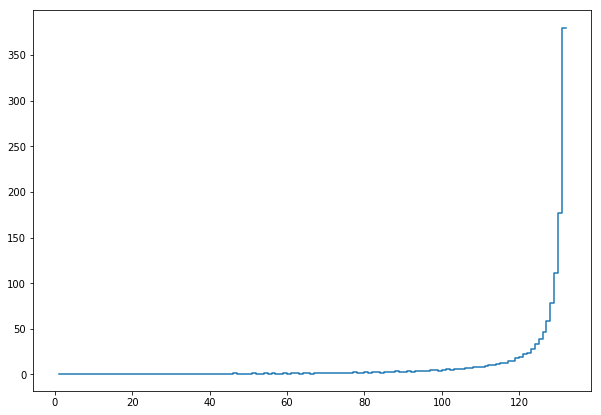

In [27]:
plt.figure(figsize=(10, 7))
plt.step(range(1, len(bin_widths) + 1), bin_widths);

We pass these assignments through a label encoder to get them into the range 0 to number of unique labels - 1.

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(unique_bin_labels)
streams_words = le.transform(
    total_streams_quantile_binned.ravel())

In [17]:
print(streams_words)
print('min = {}, max = {}'.format(streams_words.min(), streams_words.max()))

[14 11 25 ... 69 83 13]
min = 0, max = 132


Here is a histogram of the number of users in each bin. The advantage of quantile discretization is that the distribution of counts is pretty even.

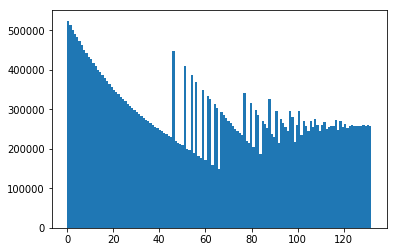

In [30]:
n, _, _ = plt.hist(streams_words, bins=len(le.classes_))

In [31]:
print('Number of points in each bin is', n)

Number of points in each bin is [524479. 514389. 501861. 491310. 482702. 471891. 462377. 450614. 443972.
 433652. 426872. 416401. 408552. 400877. 393475. 386154. 379282. 371250.
 363504. 357649. 350153. 345065. 338105. 330443. 326756. 320602. 314337.
 309014. 303673. 298930. 292911. 288482. 283184. 278910. 273199. 269622.
 264853. 261158. 256298. 252086. 248176. 244616. 239743. 236314. 233159.
 229374. 448997. 218631. 215664. 212388. 209681. 409549. 200022. 197680.
 385897. 188219. 370353. 180661. 177550. 349188. 171225. 335008. 326514.
 159409. 313071. 304412. 149588. 293263. 285597. 278494. 270406. 264501.
 257345. 251337. 245666. 239623. 234016. 340568. 220982. 215579. 315276.
 204260. 297668. 285744. 185883. 270547. 262892. 253697. 326908. 236395.
 229426. 295474. 213789. 275678. 266080. 254834. 245205. 294601. 281312.
 216615. 259731. 296503. 236054. 270054. 256968. 244145. 270206. 256086.
 276023. 259761. 244228. 259521. 268724. 248970. 255840. 257531. 257916.
 272726. 248137. 26

As a sanity check, confirm counts make sense.

In [32]:
# total for first bin
bin_min, bin_max = 101, 102
A = df['total_streams'][df['total_streams'] >= bin_min]
print((A < bin_max).sum())

524479


We can plot a similar histogram, except now based on the actual bin edges.

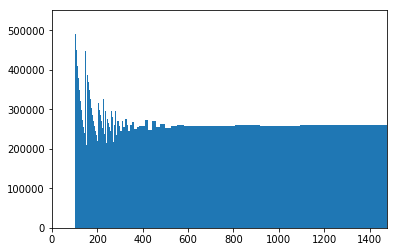

In [33]:
plt.hist(bin_edges[streams_words], bins=np.concatenate((bin_edges, [1e6])))
plt.xlim([0, bin_edges.max()]);

What does this discrete approximation look like for particular artists?

In [18]:
# add to DataFrame
df['streams_words_total_streams_quantile'] = streams_words

In [35]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled,total_streams_max_abs_scaled,streams_words_total_streams_quantile
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068,0.000047,0.000389,14
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849,0.000037,0.000379,11
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205,0.000085,0.000426,25
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110,0.000034,0.000375,10
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233,0.000734,0.001075,107


Let's look at Al Green.

In [36]:
df_al_green = df[df['artistname'] == 'Al Green']

In [37]:
df_al_green.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled,total_streams_max_abs_scaled,streams_words_total_streams_quantile
675,Al Green,732972,5342a17942be9241356822e8e99d8133,300,5.703782,0.821918,0.000673,0.001015,104
744,Al Green,732972,c8a38b3f45b85c90166e2fb8514d28eb,105,4.653960,0.287671,0.000014,0.000355,4
891,Al Green,732972,ef07358120db726a17c89a465bfd0b36,200,5.298317,0.547945,0.000335,0.000676,78
959,Al Green,732972,4acc7c1be716b7ac7051c4b56034ea7c,150,5.010635,0.410959,0.000166,0.000507,48
1609,Al Green,732972,060d9589ce3d090cfd878d966214b37e,112,4.718499,0.306849,0.000037,0.000379,11


Below is a plot of observed streams compared to binned streams. The vertical bars indicate the bin edges. Notice that the first few bins match observed streams exactly, but later bins do not due to the coarseness of the discretization and the quantile nature of the binning.

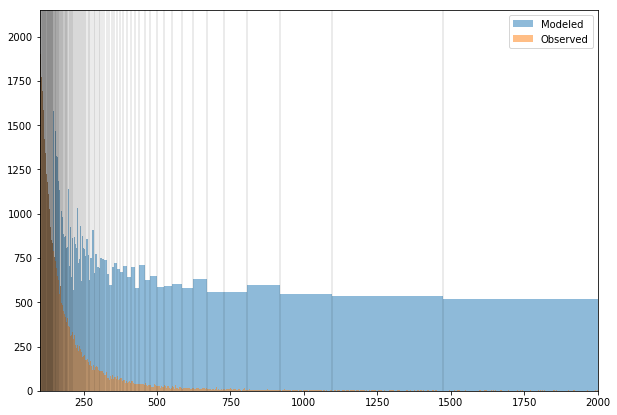

In [38]:
plt.figure(figsize=(10, 7))

# plot modeled
n_modeled, bins_modeled, _ = plt.hist(
    bin_edges[df_al_green['streams_words_total_streams_quantile']],
    bins=np.concatenate((bin_edges, [1e6])), alpha=0.5, label='Modeled')

# plot observed
n_obs, bins_obs, _ = plt.hist(
    df_al_green['total_streams'], bins=np.unique(df_al_green['total_streams']),
    alpha=0.5, label='Observed')

for edge in bin_edges:
    plt.axvline(edge, alpha=0.1, c='k')

plt.legend(loc='best')
plt.xlim([100, 2000]);

Here are the same plots, as probability densities. They appear to match up better. Because the bins are wide, the corresponding probability density is lower (density = probability/bin_size).

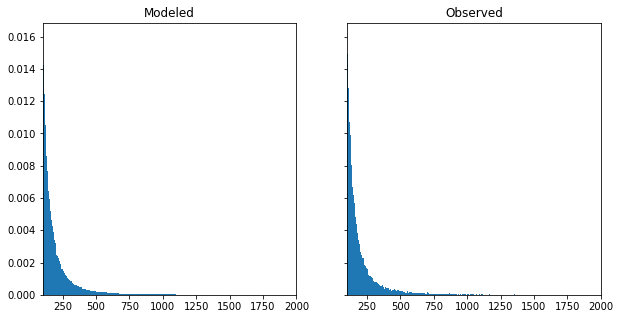

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].hist(
    bin_edges[df_al_green['streams_words_total_streams_quantile']],
    bins=np.concatenate((bin_edges, [1e6])), density=True)
ax[0].set_xlim([100, 2000])
ax[0].set_title('Modeled')
ax[1].hist(
    df_al_green['total_streams'], bins=np.unique(df_al_green['total_streams']), density=True)
ax[1].set_title('Observed');

In [40]:
# TODO: Sanity check to make sure numbers add up.

The words distribution looks like this.

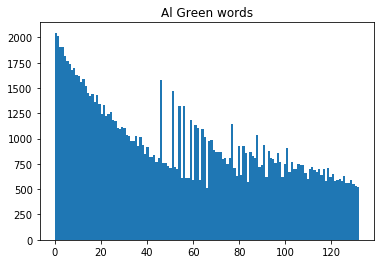

In [41]:
plt.hist(df_al_green['streams_words_total_streams_quantile'], bins=len(le.classes_))
plt.title('Al Green words');

Finally, compute the discretization error. To do that, the final bin, which has no right edge, must be discarded.

In [42]:
# observed
total_streams_observed = \
    df_al_green[df_al_green['total_streams'] < bin_edges[-1]]['total_streams'].sum()

# modeled
not_last_bin = df_al_green['streams_words_total_streams_quantile'] < len(le.classes_) - 1
streams_words_al_green = df_al_green[not_last_bin]['streams_words_total_streams_quantile']
total_streams_modeled = int((
    bin_edges[streams_words_al_green] + (bin_widths[streams_words_al_green] - 1)/2).sum())

print('Observed total streams is', total_streams_observed)
print('Modeled total streams is', total_streams_modeled)
print('Percentage difference is {:f}'.format(
    100 * (total_streams_modeled - total_streams_observed)/total_streams_observed))

Observed total streams is 25748296
Modeled total streams is 25776954
Percentage difference is 0.111301


#### Uniform Binning

Next we'll perform the same analysis using uniform binning and compare the results.

In [19]:
n_bins = 150

enc_uniform_150 = KBinsDiscretizer(n_bins=n_bins, strategy='uniform', encode='ordinal')
total_streams_uniform_binned = enc_uniform_150.fit_transform(
    df['total_streams'].values.reshape(-1, 1))
print(total_streams_uniform_binned)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


Get bin assignments.

In [20]:
unique_bin_labels = np.unique(total_streams_uniform_binned).astype(int)
print(unique_bin_labels)
print('Number of bin assignments is', len(unique_bin_labels))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  75  76  78  79  80  81  82  83  84  86  88  90  93  96  97  98
  99 102 106 108 109 131 149]
Number of bin assignments is 97


Then bin edges and widths. Notice how the bin widths are not all the same because bins with no elements have been removed.

[1.0100000e+02 2.0715400e+03 4.0420800e+03 6.0126200e+03 7.9831600e+03
 9.9537000e+03 1.1924240e+04 1.3894780e+04 1.5865320e+04 1.7835860e+04
 1.9806400e+04 2.1776940e+04 2.3747480e+04 2.5718020e+04 2.7688560e+04
 2.9659100e+04 3.1629640e+04 3.3600180e+04 3.5570720e+04 3.7541260e+04
 3.9511800e+04 4.1482340e+04 4.3452880e+04 4.5423420e+04 4.7393960e+04
 4.9364500e+04 5.1335040e+04 5.3305580e+04 5.5276120e+04 5.7246660e+04
 5.9217200e+04 6.1187740e+04 6.3158280e+04 6.5128820e+04 6.7099360e+04
 6.9069900e+04 7.1040440e+04 7.3010980e+04 7.4981520e+04 7.6952060e+04
 7.8922600e+04 8.0893140e+04 8.2863680e+04 8.4834220e+04 8.6804760e+04
 8.8775300e+04 9.0745840e+04 9.2716380e+04 9.4686920e+04 9.6657460e+04
 9.8628000e+04 1.0059854e+05 1.0256908e+05 1.0453962e+05 1.0651016e+05
 1.0848070e+05 1.1045124e+05 1.1242178e+05 1.1439232e+05 1.1636286e+05
 1.1833340e+05 1.2030394e+05 1.2227448e+05 1.2424502e+05 1.2621556e+05
 1.2818610e+05 1.3015664e+05 1.3212718e+05 1.3409772e+05 1.3606826e+05
 1.380

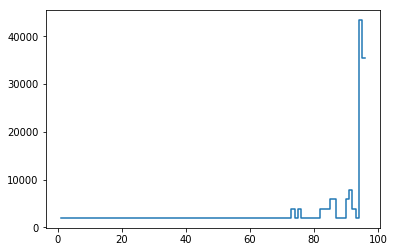

In [21]:
bin_edges = enc_uniform_150.bin_edges_[0][unique_bin_labels]
print(bin_edges)

bin_widths = np.diff(bin_edges)
plt.step(range(1, len(bin_widths) + 1), bin_widths);

Convert to words.

In [22]:
le = LabelEncoder()
le.fit(unique_bin_labels)
streams_words = le.transform(
    total_streams_uniform_binned.ravel())

print(streams_words)
print('min = {}, max = {}'.format(streams_words.min(), streams_words.max()))

[0 0 0 ... 0 0 0]
min = 0, max = 96


Plot the word histogram. As expected, the counts drop off exponentially because the bins were created uniformly.

Number of points in each bin is [3.8658129e+07 8.8987000e+04 1.4848000e+04 5.4760000e+03 2.7810000e+03
 1.5640000e+03 1.0580000e+03 7.0900000e+02 4.9800000e+02 3.5300000e+02
 2.8700000e+02 2.3600000e+02 1.4500000e+02 1.5700000e+02 1.2700000e+02
 1.1200000e+02 1.0000000e+02 8.7000000e+01 6.9000000e+01 6.4000000e+01
 7.4000000e+01 5.8000000e+01 3.0000000e+01 4.6000000e+01 4.1000000e+01
 3.6000000e+01 3.4000000e+01 3.5000000e+01 2.7000000e+01 3.1000000e+01
 2.2000000e+01 1.8000000e+01 2.2000000e+01 1.8000000e+01 1.7000000e+01
 1.9000000e+01 8.0000000e+00 1.5000000e+01 1.1000000e+01 9.0000000e+00
 6.0000000e+00 1.4000000e+01 9.0000000e+00 8.0000000e+00 6.0000000e+00
 8.0000000e+00 7.0000000e+00 2.0000000e+00 5.0000000e+00 6.0000000e+00
 5.0000000e+00 4.0000000e+00 5.0000000e+00 6.0000000e+00 4.0000000e+00
 7.0000000e+00 4.0000000e+00 8.0000000e+00 3.0000000e+00 8.0000000e+00
 2.0000000e+00 4.0000000e+00 2.0000000e+00 1.0000000e+00 1.0000000e+00
 3.0000000e+00 2.0000000e+00 2.0000000e+00 2.

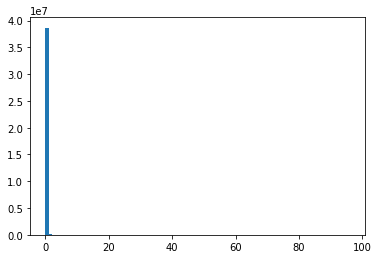

In [47]:
n, bins, _ = plt.hist(streams_words, bins=len(le.classes_))
print('Number of points in each bin is', n)

The counts in log scale look like this.

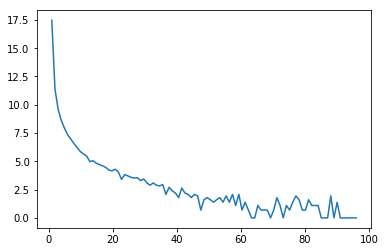

In [48]:
plt.plot(bins[1:], np.log(n));

Plot the histogram again in terms of absolute streams (again on a log scale).

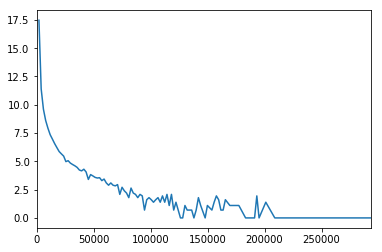

In [49]:
n, bins = np.histogram(bin_edges[streams_words], bins=np.concatenate((bin_edges, [1e6])))
plt.plot(bins[1:], np.log(n))
plt.xlim([0, bin_edges.max()]);

Let's break it down again to the artist level.

In [50]:
df['streams_words_total_streams_uniform'] = streams_words
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled,total_streams_max_abs_scaled,streams_words_total_streams_quantile,streams_words_total_streams_uniform
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068,0.000047,0.000389,14,0
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849,0.000037,0.000379,11,0
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205,0.000085,0.000426,25,0
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110,0.000034,0.000375,10,0
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233,0.000734,0.001075,107,0


In [51]:
df_al_green = df[df['artistname'] == 'Al Green']

Here's a histogram comparison. Because the bin widths are large, the first bin has a lot of elements.

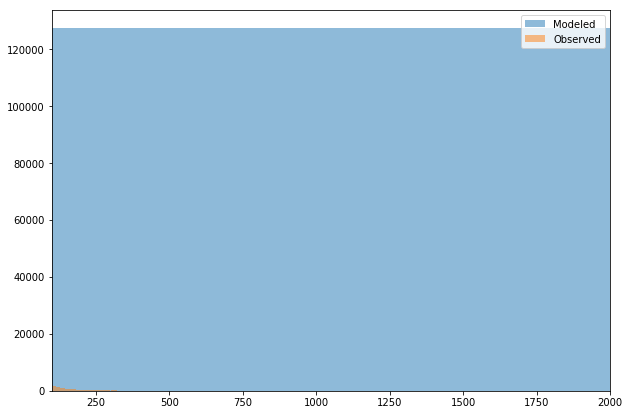

In [52]:
plt.figure(figsize=(10, 7))

# plot modeled
n_modeled, bins_modeled, _ = plt.hist(
    bin_edges[df_al_green['streams_words_total_streams_uniform']],
    bins=np.concatenate((bin_edges, [1e6])), alpha=0.5, label='Modeled')

# plot observed
n_obs, bins_obs, _ = plt.hist(
    df_al_green['total_streams'], bins=np.unique(df_al_green['total_streams']),
    alpha=0.5, label='Observed')

for edge in bin_edges:
    plt.axvline(edge, alpha=0.1, c='k')

plt.legend(loc='best')
plt.xlim([100, 2000]);

Here are the densities. The modeled probabilities shift down as expected.

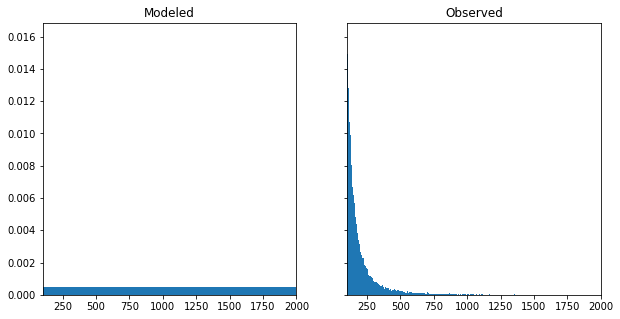

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].hist(
    bin_edges[df_al_green['streams_words_total_streams_uniform']],
    bins=np.concatenate((bin_edges, [1e6])), density=True)
ax[0].set_xlim([100, 2000])
ax[0].set_title('Modeled')
ax[1].hist(
    df_al_green['total_streams'], bins=np.unique(df_al_green['total_streams']), density=True)
ax[1].set_title('Observed');

It's pretty clear that this approach is worse than the previous one because it doesn't capture the variability as well. Below is the discretization error for Al Green. It is 440% because the bins are so wide.

In [54]:
# modeled
not_last_bin = df_al_green['streams_words_total_streams_uniform'] < len(le.classes_) - 1
streams_words_al_green = df_al_green[not_last_bin]['streams_words_total_streams_uniform']
total_streams_modeled = int((
    bin_edges[streams_words_al_green] + (bin_widths[streams_words_al_green] - 1)/2).sum())

print('Observed total streams is', total_streams_observed)
print('Modeled total streams is', total_streams_modeled)
print('Percentage difference is {:f}'.format(
    100 * (total_streams_modeled - total_streams_observed)/total_streams_observed))

Observed total streams is 25748296
Modeled total streams is 139095561
Percentage difference is 440.212684


#### Other Observations

We can repeat the same steps for our other inputs (log streams, average daily streams, etc.).

In [23]:
def discretize(values, n_bins, strategy):
    """Discretize values into bins.
    
        Args:
            values (np.array): Array of values to discretize
            n_bins (int): Number of bins
            strategy (str): Discretization strategy
        
        Returns:
            streams_words (np.array): "Words" corresponding to discretized values
            bin_edges (np.array): Left bin edges of discretized values
            n_elem_in_bins (np.array): Number of elements in each bin
    
    """
    discretizer = KBinsDiscretizer(
        n_bins=n_bins, strategy=strategy, encode='ordinal')
    binned_values = discretizer.fit_transform(values.reshape(-1, 1))
    
    # get bin edges
    unique_bin_labels = np.unique(binned_values).astype(int)
    bin_edges = discretizer.bin_edges_[0][unique_bin_labels]
    
    # convert to words
    le = LabelEncoder()
    le.fit(unique_bin_labels)
    streams_words = le.transform(binned_values.ravel())
    
    n_elem_in_bins, _ = np.histogram(streams_words, bins=len(le.classes_))
    
    return streams_words, bin_edges, n_elem_in_bins

In [174]:
n_bins = 150

# log streams
streams_words, bin_edges_log_quantile, n_elem_log_quantile = discretize(
    df['log_total_streams'].values, n_bins, strategy='quantile')
df['streams_words_log_total_streams_quantile'] = streams_words

streams_words, bin_edges_log_uniform, n_elem_log_uniform = discretize(
    df['log_total_streams'].values, n_bins, strategy='uniform')
df['streams_words_log_total_streams_uniform'] = streams_words

# average daily streams
streams_words, bin_edges_avg_quantile, n_elem_avg_quantile = discretize(
    df['avg_daily_streams'].values, n_bins, strategy='quantile')
df['streams_words_avg_daily_streams_quantile'] = streams_words

streams_words, bin_edges_avg_uniform, n_elem_avg_uniform = discretize(
    df['avg_daily_streams'].values, n_bins, strategy='uniform')
df['streams_words_avg_daily_streams_uniform'] = streams_words

# min/max scaled
streams_words, bin_edges_min_max_quantile, n_elem_min_max_quantile = discretize(
    df['total_streams_min_max_scaled'].values, n_bins, strategy='quantile')
df['streams_words_min_max_streams_quantile'] = streams_words

streams_words, bin_edges_min_max_uniform, n_elem_min_max_uniform = discretize(
    df['total_streams_min_max_scaled'].values, n_bins, strategy='uniform')
df['streams_words_min_max_streams_uniform'] = streams_words

# max/abs scaled
n_bins = 120  # need smaller size due to discretization

streams_words, bin_edges_max_abs_quantile, n_elem_max_abs_quantile = discretize(
    df['total_streams_max_abs_scaled'].values, n_bins, strategy='quantile')
df['streams_words_max_abs_streams_quantile'] = streams_words

streams_words, bin_edges_max_abs_uniform, n_elem_max_abs_uniform = discretize(
    df['total_streams_max_abs_scaled'].values, n_bins, strategy='uniform')
df['streams_words_max_abs_streams_uniform'] = streams_words

Here's what the DataFrame looks like now.

In [175]:
df.head()

,artistname,canonical_artistid,userid,total_streams,log_total_streams,avg_daily_streams,total_streams_min_max_scaled,total_streams_max_abs_scaled,streams_words_total_streams_quantile,streams_words_log_total_streams_quantile,streams_words_log_total_streams_uniform,streams_words_avg_daily_streams_quantile,streams_words_avg_daily_streams_uniform,streams_words_min_max_streams_quantile,streams_words_min_max_streams_uniform,streams_words_max_abs_streams_quantile,streams_words_max_abs_streams_uniform
0,K-391,990724,48c88ede3ea5cc4539cb9b5d526e7342,115,4.744932,0.315068,0.000047,0.000389,14,14,2,14,0,14,0,14,0
1,Los Ángeles Azules,980554,975626d69ceb1987eba8eaefec9edbe0,112,4.718499,0.306849,0.000037,0.000379,11,11,1,11,0,11,0,11,0
2,Anderson .Paak,732846,2bb9a12610501bf1670d76877efe4b01,126,4.836282,0.345205,0.000085,0.000426,25,25,4,25,0,25,0,25,0
3,Ozuna,915232,5c2a28302fe7c95805f19ccbc357a24f,111,4.709530,0.304110,0.000034,0.000375,10,10,1,10,0,10,0,10,0
4,Los Yaguaru,436462,eb0bf4a499ae5d9aee55101808250499,318,5.762051,0.871233,0.000734,0.001075,107,107,21,107,0,107,0,91,0


Let's plot some densities to see how they compare.

In [176]:
def plot_density(ax, values, bin_edges):
    """Plot probability density."""
    ax.hist(
        bin_edges[values],
        bins=np.concatenate((bin_edges, [1e6])), density=True)
    
    for edge in bin_edges:
        ax.axvline(edge, alpha=0.1, c='k')

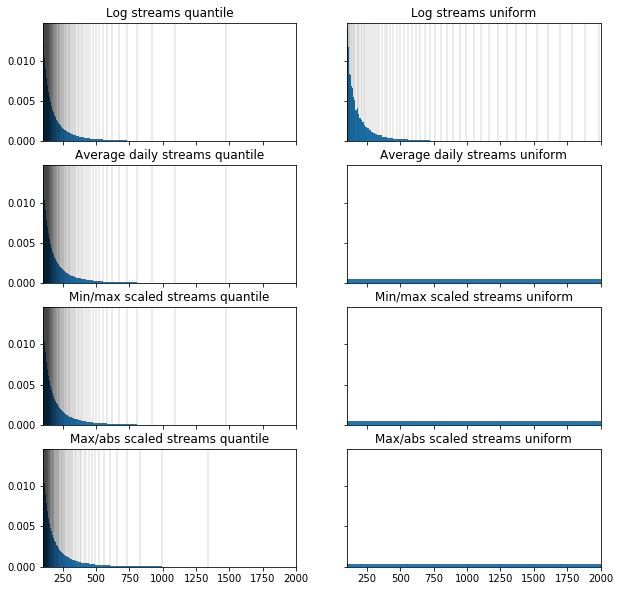

In [177]:
fig, ax = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)

plot_density(
    ax[0, 0], df['streams_words_log_total_streams_quantile'], np.exp(bin_edges_log_quantile))
ax[0, 0].set_title('Log streams quantile')
plot_density(
    ax[0, 1], df['streams_words_log_total_streams_uniform'], np.exp(bin_edges_log_uniform))
ax[0, 1].set_title('Log streams uniform')

plot_density(
    ax[1, 0], df['streams_words_avg_daily_streams_quantile'], 365 * bin_edges_avg_quantile)
ax[1, 0].set_title('Average daily streams quantile')
plot_density(
    ax[1, 1], df['streams_words_avg_daily_streams_uniform'], 365 * bin_edges_avg_uniform)
ax[1, 1].set_title('Average daily streams uniform')

plot_density(
    ax[2, 0], df['streams_words_min_max_streams_quantile'],
    min_max_scaler.inverse_transform(bin_edges_min_max_quantile.reshape(-1, 1)).squeeze())
ax[2, 0].set_title('Min/max scaled streams quantile')
plot_density(
    ax[2, 1], df['streams_words_min_max_streams_uniform'],
    min_max_scaler.inverse_transform(bin_edges_min_max_uniform.reshape(-1, 1)).squeeze())
ax[2, 1].set_title('Min/max scaled streams uniform')

plot_density(
    ax[3, 0], df['streams_words_max_abs_streams_quantile'],
    max_abs_scaler.inverse_transform(bin_edges_max_abs_quantile.reshape(-1, 1)).squeeze())
ax[3, 0].set_title('Max/abs scaled streams quantile')
plot_density(
    ax[3, 1], df['streams_words_max_abs_streams_uniform'],
    max_abs_scaler.inverse_transform(bin_edges_max_abs_uniform.reshape(-1, 1)).squeeze())
ax[3, 1].set_title('Max/abs scaled streams uniform')

ax[0, 0].set_xlim([100, 2000]);

Based on this, it looks like the quantile approaches are all identical or very similar. Uniform binning only works well on log streams. So for simplicity, we'll only look at log streams quantile or uniform.

### Corpus Generation

The next step is to generate the corpus. It involves counting the number of times each word (corresponding to streams ranges for users) occurs for each artist. Each artist is then a bag of users, or a bag of streams. Now the binned values are simply labels.

In [178]:
def transform_to_document_word_matrix(df, varname):
    """Transform in matrix of shape (N_a, N_w)."""
    num_words = len(np.unique(df[varname]))
    
    return df.groupby('artistname').apply(
        lambda x: pd.Series([sum(x[varname] == i) for i in range(num_words)]))

Transform quantile-binned log streams into a document word matrix.

In [179]:
dw_matrix_log_streams_quantile = transform_to_document_word_matrix(
    df, 'streams_words_log_total_streams_quantile')

In [180]:
dw_matrix_log_streams_quantile.head()

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
artistname,,,,,,,,,,,,,,,,,,,,,
(Hed)p.e.,18,22,26,33,22,18,21,18,17,19,...,5,2,1,5,4,5,8,9,4,1
(hed) p.e.,65,44,42,53,43,51,44,29,55,39,...,20,27,19,32,23,17,18,20,26,17
10 Years,30,28,23,16,19,24,15,23,20,11,...,8,5,5,7,8,3,6,7,3,7
12 Stones,20,20,14,23,17,13,11,21,15,19,...,5,3,3,5,3,4,5,3,4,5
12th Planet,32,24,30,18,23,18,26,22,21,23,...,1,1,2,2,0,1,1,0,1,1


In [181]:
print(dw_matrix_log_streams_quantile.values)

[[ 18  22  26 ...   9   4   1]
 [ 65  44  42 ...  20  26  17]
 [ 30  28  23 ...   7   3   7]
 ...
 [432 467 430 ...  72  72  92]
 [ 32  25  21 ...   3  10 162]
 [ 90  99 117 ...  21  35  38]]


This is your usual document-term matrix in dense form. Save it to CSV.

In [68]:
dw_matrix_log_streams_quantile.to_csv(
    'artist_listener_corpus.csv', header=False, index=False)

It can also be converted into the sparse representation needed to pass into the HDP transformer below, which is a list of tuples.

In [182]:
corpus_log_streams_quantile = [[(i, cnt) for i, cnt in enumerate(word_counts) if cnt > 0]
    for word_counts in dw_matrix_log_streams_quantile.values]

In [183]:
print(len(corpus_log_streams_quantile))

2760


Display first 1000 documents in the corpus.

In [184]:
print(corpus_log_streams_quantile[:1000])

[[(0, 18), (1, 22), (2, 26), (3, 33), (4, 22), (5, 18), (6, 21), (7, 18), (8, 17), (9, 19), (10, 11), (11, 21), (12, 21), (13, 19), (14, 14), (15, 15), (16, 11), (17, 15), (18, 11), (19, 9), (20, 12), (21, 18), (22, 15), (23, 14), (24, 13), (25, 16), (26, 12), (27, 13), (28, 14), (29, 18), (30, 13), (31, 15), (32, 10), (33, 14), (34, 10), (35, 14), (36, 10), (37, 18), (38, 9), (39, 13), (40, 6), (41, 12), (42, 8), (43, 8), (44, 12), (45, 7), (46, 20), (47, 7), (48, 5), (49, 11), (50, 7), (51, 12), (52, 5), (53, 5), (54, 15), (55, 8), (56, 18), (57, 5), (58, 7), (59, 8), (60, 8), (61, 9), (62, 7), (63, 5), (64, 13), (65, 14), (66, 3), (67, 11), (68, 10), (69, 13), (70, 13), (71, 12), (72, 11), (73, 10), (74, 10), (75, 6), (76, 6), (77, 15), (78, 8), (79, 9), (80, 9), (81, 16), (82, 9), (83, 10), (84, 11), (85, 15), (86, 10), (87, 12), (88, 14), (89, 12), (90, 8), (91, 7), (92, 9), (93, 8), (94, 6), (95, 6), (96, 13), (97, 11), (98, 11), (99, 6), (100, 14), (101, 11), (102, 3), (103, 17)

Inspect document lengths. Most have all words.

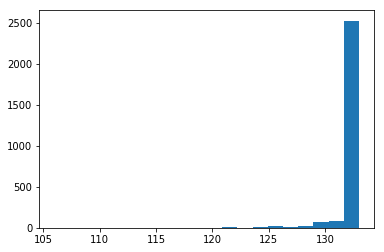

In [76]:
document_lengths = np.array([len(d) for d in corpus_log_streams_quantile])
plt.hist(document_lengths, bins=20);

Plot the corpus. Each row is an artist, each column represents users with streams between certain amounts, with amounts increasing from left to right. Each cell corresponds to the number of users in that group. The colorbar only goes up to 1000 (1000 users). Note the sparsity.

First sort artists roughly by popularity.

In [33]:
sort_idx = np.argsort(dw_matrix_log_streams_quantile.sum(axis=1))
dw_matrix_log_streams_quantile.sum(axis=1).iloc[sort_idx]

artistname
Nobunny                                                     1001
Big Band Jazz de México                                     1002
Mary Chapin Carpenter                                       1002
Shane MacGowan                                              1003
Dazaranha                                                   1003
Kid Patrol                                                  1003
Brad Williams                                               1004
Great American Ghost                                        1004
Yavuz Çetin                                                 1004
Life On Repeat                                              1005
Shoddy Boi                                                  1005
Diane Arkenstone                                            1005
Sunstorm                                                    1005
Matt Nathanson                                              1006
Joohyun Park                                                1006
Brokencyde    

Then plot.

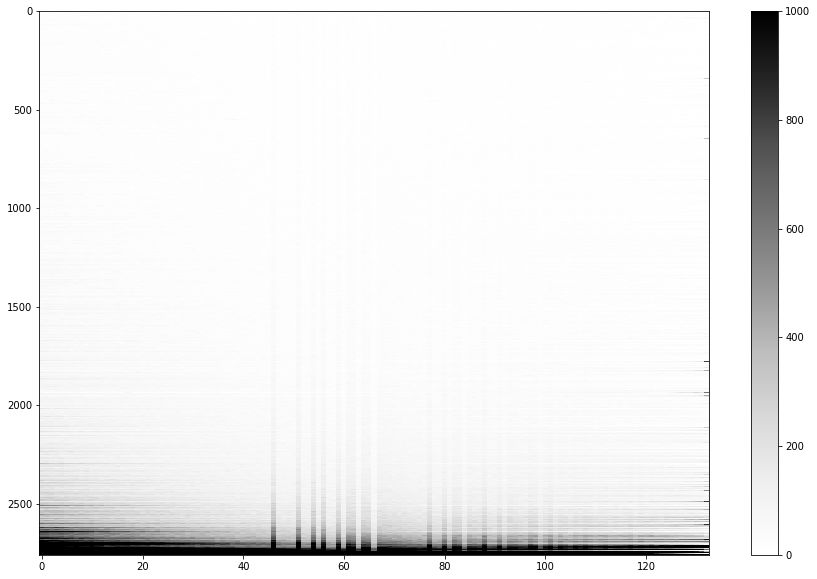

In [185]:
plt.figure(figsize=(15, 10))
plt.imshow(
    dw_matrix_log_streams_quantile.values[sort_idx], vmin=0, vmax=1000, aspect='auto', cmap=plt.cm.Greys)
plt.colorbar();

In [186]:
# TODO: Add bin merge and split to get rid of artifacts and break high streams into more groups

Now produce the same dataset for the uniform binning case.

In [111]:
dw_matrix_log_streams_uniform = transform_to_document_word_matrix(
    df, 'streams_words_log_total_streams_uniform')

In [116]:
dw_matrix_log_streams_uniform.head()

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
artistname,,,,,,,,,,,,,,,,,,,,,
(Hed)p.e.,139,107,95,79,99,91,75,62,63,37,...,0,0,0,0,0,0,0,0,0,0
(hed) p.e.,298,262,241,199,239,203,229,196,188,150,...,0,0,0,0,0,0,0,0,0,0
10 Years,140,109,96,61,94,74,59,62,70,48,...,0,0,0,0,0,0,0,0,0,0
12 Stones,107,111,69,67,67,56,56,51,51,47,...,0,0,0,0,0,0,0,0,0,0
12th Planet,145,123,99,82,79,67,66,57,63,41,...,0,0,0,0,0,0,0,0,0,0


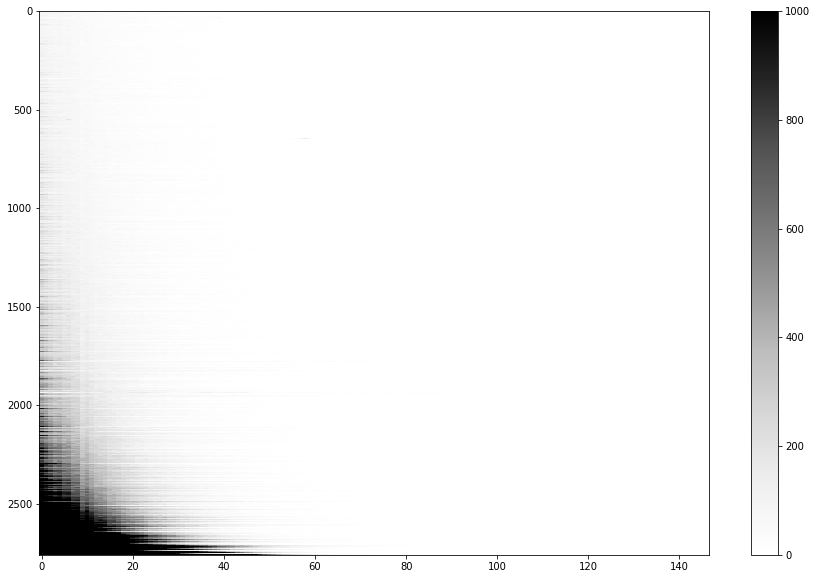

In [120]:
plt.figure(figsize=(15, 10))
plt.imshow(
    dw_matrix_log_streams_uniform.values[sort_idx], vmin=0, vmax=1000, aspect='auto', cmap=plt.cm.Greys)
plt.colorbar();

## Methods

Several methods can be used.

### Latent Dirichlet Allocation

With LDA, you have to specify the number of clusters beforehand, and the number can't grow with the data. However, it is a hierarchical approach, and is part of sklearn.

First split into training and test sets.

In [188]:
from sklearn.model_selection import train_test_split

num_artists = len(dw_matrix_log_streams_quantile)

artists_train, artists_test = train_test_split(
    range(num_artists), train_size=0.75, random_state=0)

dw_matrix_log_streams_quantile_train = dw_matrix_log_streams_quantile.iloc[artists_train]
dw_matrix_log_streams_quantile_test = dw_matrix_log_streams_quantile.iloc[artists_test]

Then create an LDA model with cross-validation to evaluate using different numbers of topics.

In [189]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

cv_folds = 5
params = {'n_components': range(3, 8)}

lda = LatentDirichletAllocation(
    max_iter=5,
    learning_method='online', learning_offset=50.,
    random_state=0)

lda_cv_estimator = GridSearchCV(lda, param_grid=params, cv=cv_folds)

Train the model.

In [191]:
from time import time

t0 = time()
lda_cv_estimator.fit(dw_matrix_log_streams_quantile_train)
print('Done in %0.3fs.' % (time() - t0))

Done in 400.050s.


Inspect the results.

In [192]:
print(lda_cv_estimator.cv_results_)

{'mean_fit_time': array([11.08248396, 12.5053966 , 14.18798776, 13.18465781, 12.18397365]), 'std_fit_time': array([0.39940731, 1.57965045, 1.48998247, 2.32335106, 0.48859598]), 'mean_score_time': array([0.59875355, 0.52371397, 0.62456112, 0.52837377, 0.51813297]), 'std_score_time': array([0.18607478, 0.04117748, 0.16312667, 0.0434972 , 0.02593512]), 'param_n_components': masked_array(data=[3, 4, 5, 6, 7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_components': 3}, {'n_components': 4}, {'n_components': 5}, {'n_components': 6}, {'n_components': 7}], 'split0_test_score': array([-23012455.12471214, -23006491.19820064, -23004656.52045963,
       -23005164.59048948, -23006629.08347951]), 'split1_test_score': array([-25561929.22352764, -25561867.38834779, -25561410.1651479 ,
       -25562738.40244781, -25564332.95036021]), 'split2_test_score': array([-21989070.21911147, -21986282.41907384, -21984860.44822013,
       

Here are the number of topics for the best estimator.

In [193]:
best_lda_estimator = lda_cv_estimator.best_estimator_
print(best_lda_estimator.n_components)

5


Here are the distributions over words (i.e., streams ranges) for different user types. As expected, one user type corresponds to very high streams per day, another to very low streams, and a few to more average levels of streams. Notice the oscillatory behavior in the middle of several lines. This may be an artifact of discretization (consult the corpus plot above).

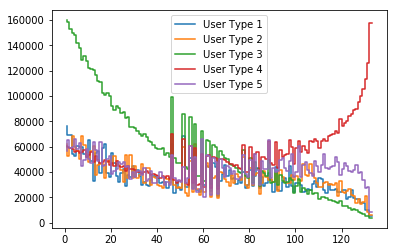

In [194]:
num_words = dw_matrix_log_streams_quantile.shape[1]

for i in range(best_lda_estimator.n_components):
    plt.step(
        range(1, num_words + 1), best_lda_estimator.components_[i],
        label='User Type {}'.format(i + 1))

plt.legend(loc='best');

These are full distributions, so values are non-zero over every bin, meaning there's some chance that a diehard fan doesn't listen much on a given day, or a chance that someone who doesn't listen much listens a lot. This is exactly what you'd expect.

You can plot the user groups in terms of absolute streams as well.

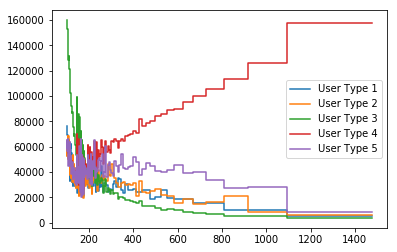

In [195]:
for i in range(best_lda_estimator.n_components):
    plt.step(
        np.exp(
            bin_edges_log_quantile), best_lda_estimator.components_[i],
            label='User Type {}'.format(i + 1))

plt.legend(loc='best');

Average streams for each group can then be computed.

First compute empirical bin means.

In [196]:
bin_assignments = np.digitize(df['log_total_streams'], bin_edges_log_quantile)
streams_bin_means = [
    np.exp(df['log_total_streams'])[bin_assignments == i].mean()
    for i in range(1, len(bin_edges_log_quantile) + 1)]

Then compute average streams.

In [197]:
for i in range(best_lda_estimator.n_components):
    word_prob = best_lda_estimator.components_[i]/best_lda_estimator.components_[i].sum()
    print('Mean streams for type', i + 1, 'is', word_prob.dot(streams_bin_means))

Mean streams for type 1 is 203.6941519983562
Mean streams for type 2 is 208.21289753837996
Mean streams for type 3 is 164.19959144792878
Mean streams for type 4 is 346.36820412083995
Mean streams for type 5 is 234.68724026035653


So a diehard fan is about twice as engaged as a casual listener.

Get the perplexity score on the test data.

In [198]:
print(lda_cv_estimator.score(dw_matrix_log_streams_quantile_test))

-68805074.85222052


Transform both train and test sets.

In [199]:
topic_matrix_log_streams_quantile = lda_cv_estimator.transform(
    dw_matrix_log_streams_quantile)

Now each artist has a distribution over user types.

In [200]:
print(topic_matrix_log_streams_quantile.shape)

(2760, 5)


Here is a plot of user type distributions for Ozuna, Al Green, and Nobunny.

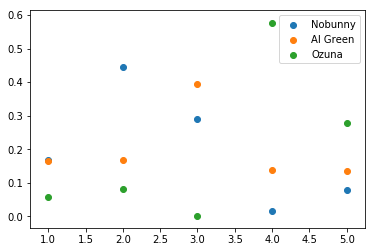

In [201]:
def get_index(artistname):
    return dw_matrix_log_streams_quantile.index.get_loc(artistname)

def plot_user_type_distribution(artistname):
    plt.scatter(
        range(1, best_lda_estimator.n_components + 1),
        topic_matrix_log_streams_quantile[get_index(artistname)], label=artistname)

for artist in ['Nobunny', 'Al Green', 'Ozuna']:
    plot_user_type_distribution(artist)

plt.legend(loc='best');

Perform the same analysis with the uniformly-binned data.

In [123]:
dw_matrix_log_streams_uniform_train = dw_matrix_log_streams_uniform.iloc[artists_train]
dw_matrix_log_streams_uniform_test = dw_matrix_log_streams_uniform.iloc[artists_test]

lda_cv_estimator_uniform = GridSearchCV(
    LatentDirichletAllocation(
        max_iter=5,
        learning_method='online', learning_offset=50.,
        random_state=0),
    param_grid=params, cv=cv_folds)

t0 = time()
lda_cv_estimator_uniform.fit(dw_matrix_log_streams_uniform_train)
print('Done in %0.3fs.' % (time() - t0))

Done in 288.999s.


In [124]:
best_lda_estimator_uniform = lda_cv_estimator_uniform.best_estimator_
print(best_lda_estimator_uniform.n_components)

4


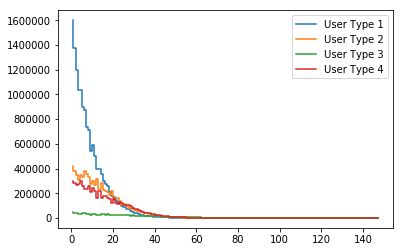

In [126]:
num_words = dw_matrix_log_streams_uniform.shape[1]

for i in range(best_lda_estimator_uniform.n_components):
    plt.step(
        range(1, num_words + 1), best_lda_estimator_uniform.components_[i],
        label='User Type {}'.format(i + 1))

plt.legend(loc='best');

Notice the long-tailed nature of the groups. Here is the log likelihood.

In [137]:
print(lda_cv_estimator_uniform.score(dw_matrix_log_streams_uniform_test))

-49685979.01455423


In [463]:
# TODO: get distributions over user OR artist metadata
# This is more complicated than expected: need to turn the plot upside-down
# Get user type breakdown as function of popularity

### Hierarchical Dirichlet Process

Create a dictionary.

In [465]:
from gensim import corpora

dictionary = corpora.Dictionary(
    [['{:03}'.format(i) for i in range(num_words)]])
print(dictionary.token2id)

{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20, '021': 21, '022': 22, '023': 23, '024': 24, '025': 25, '026': 26, '027': 27, '028': 28, '029': 29, '030': 30, '031': 31, '032': 32, '033': 33, '034': 34, '035': 35, '036': 36, '037': 37, '038': 38, '039': 39, '040': 40, '041': 41, '042': 42, '043': 43, '044': 44, '045': 45, '046': 46, '047': 47, '048': 48, '049': 49, '050': 50, '051': 51, '052': 52, '053': 53, '054': 54, '055': 55, '056': 56, '057': 57, '058': 58, '059': 59, '060': 60, '061': 61, '062': 62, '063': 63, '064': 64, '065': 65, '066': 66, '067': 67, '068': 68, '069': 69, '070': 70, '071': 71, '072': 72, '073': 73, '074': 74, '075': 75, '076': 76, '077': 77, '078': 78, '079': 79, '080': 80, '081': 81, '082': 82, '083': 83, '084': 84, '085': 85, '086': 86, '087': 87, '088': 88, '089': 89, '090': 90, '091': 9

Create the model.

In [466]:
from gensim.sklearn_api import HdpTransformer

model = HdpTransformer(id2word=dictionary)

Fit the model.

In [467]:
distr = model.fit_transform(corpus_log_streams_quantile)

In [468]:
distr.shape

(2760, 150)

In [474]:
distr[0]

array([0.09597038, 0.        , 0.21129975, 0.2952539 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03805339,
       0.        , 0.        , 0.        , 0.        , 0.03779333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02575065, 0.        ,
       0.01309245, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03315181,
       0.        , 0.0350416 , 0.        , 0.02690721, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [86]:
df.memory_usage()

Index                                              80
artistname                                  310212600
canonical_artistid                          310212600
userid                                      310212600
total_streams                               310212600
log_total_streams                           310212600
avg_daily_streams                           310212600
total_streams_min_max_scaled                310212600
total_streams_max_abs_scaled                310212600
streams_words_total_streams_quantile        310212600
streams_words_total_streams_uniform         310212600
streams_words_log_total_streams_quantile    310212600
streams_words_log_total_streams_uniform     310212600
streams_words_avg_daily_streams_quantile    310212600
streams_words_avg_daily_streams_uniform     310212600
streams_words_min_max_streams_quantile      310212600
streams_words_min_max_streams_uniform       310212600
streams_words_max_abs_streams_quantile      310212600
streams_words_max_abs_stream

In [87]:
df.shape

(38776575, 18)